In [3]:
import pandas as pd
import glob

file_paths = glob.glob("zoneRaw/Datos_SIATA/Estacion_nivel*.csv")
df = pd.concat((pd.read_csv(file) for file in file_paths), ignore_index=True)

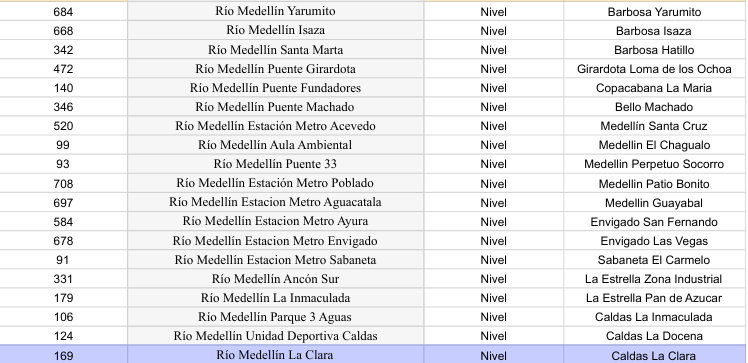

In [4]:
codigosMedellin = [93] 


In [ ]:
  # M     P
# 355 -> 619 -> 93
# 207 -> 619 -> 93
# 202 -> 311 -> 93
# 419 -> 311 -> 93
# 249 -> 4   -> 93
# 197 -> 25  -> 93

In [5]:
df = df[df["codigo"]== 93]

In [6]:
columnas_fecha = ['fecha_hora']  

for columna in columnas_fecha:
    try:
        df[columna] = pd.to_datetime(df[columna], errors='coerce')
    except Exception as e:
        print(f"Error al convertir la columna {columna}: {e}")

In [7]:
df = df[ (df["fecha_hora"] >= "2019-12-26 15:59:00") &(df["fecha_hora"] <= "2024-07-19 10:35:00")]

In [8]:
df.shape

(2280344, 4)

In [9]:
df.columns

Index(['codigo', 'fecha_hora', 'nivel', 'calidad'], dtype='object')

In [10]:
df = df[(df["calidad"] == 1) | (df["calidad"] == 2)]

In [11]:
df.shape

(2207841, 4)

In [12]:
df["nivel_metros"] = df["nivel"]/100

In [14]:
df = df[['codigo', 'fecha_hora', 'nivel_metros']]

In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta

df = df.sort_values(by=['codigo', 'fecha_hora']).reset_index(drop=True)

df['diferencia_tiempo'] = df.groupby('codigo')['fecha_hora'].diff().dt.total_seconds() / 60

saltos_minuto = df[(df['diferencia_tiempo'] > 1) & (df['diferencia_tiempo'].notnull())]

nuevas_filas = []

for _, row in saltos_minuto.iterrows():
    fechas_faltantes = pd.date_range(
        start=row['fecha_hora'] - timedelta(minutes=row['diferencia_tiempo'] - 1),
        end=row['fecha_hora'] - timedelta(minutes=1),
        freq='1min'
    )
    nuevas_filas.extend([{
        'codigo': row['codigo'],
        'fecha_hora': fecha,
        'nivel_metros': np.nan,
        'diferencia_tiempo': 1 
    } for fecha in fechas_faltantes])
    
nuevas_filas_df = pd.DataFrame(nuevas_filas)

df_completo = pd.concat([df, nuevas_filas_df]).sort_values(by=['codigo', 'fecha_hora']).reset_index(drop=True)
df_completo

,codigo,fecha_hora,nivel_metros,diferencia_tiempo
0,93,2019-12-26 15:59:00,0.3913,NaN
1,93,2019-12-26 16:00:00,0.3913,1.0
2,93,2019-12-26 16:01:00,0.3902,1.0
3,93,2019-12-26 16:02:00,0.3783,1.0
4,93,2019-12-26 16:03:00,0.3935,1.0
...,...,...,...,...
2401592,93,2024-07-19 10:31:00,0.6627,1.0
2401593,93,2024-07-19 10:32:00,0.6601,1.0
2401594,93,2024-07-19 10:33:00,0.6596,1.0
2401595,93,2024-07-19 10:34:00,0.6625,1.0


In [17]:
df_completo['fecha_hora'] = df_completo['fecha_hora'].dt.floor('15min')

df_completo = df_completo.sort_values(by=['codigo', 'fecha_hora'])

grouped = df_completo.groupby(['codigo', 'fecha_hora']).agg(
    nivel_metros_promedio=('nivel_metros', 'mean'),
    nivel_metros_std=('nivel_metros', 'std'),
    nivel_metros_sum=('nivel_metros', 'sum'), 
    nivel_metros_min=('nivel_metros', 'min'), 
    nivel_metros_max=('nivel_metros', 'max')
)

grouped = grouped.reset_index()
grouped

,codigo,fecha_hora,nivel_metros_promedio,nivel_metros_std,nivel_metros_sum,nivel_metros_min,nivel_metros_max
0,93,2019-12-26 15:45:00,0.391300,NaN,0.391300,0.3913,0.3913
1,93,2019-12-26 16:00:00,0.388120,0.005379,5.821801,0.3783,0.3978
2,93,2019-12-26 16:15:00,0.388400,0.005355,5.826000,0.3815,0.4000
3,93,2019-12-26 16:30:00,0.386247,0.003626,5.793700,0.3805,0.3924
4,93,2019-12-26 16:45:00,0.382620,0.005463,5.739300,0.3761,0.3956
...,...,...,...,...,...,...,...
160007,93,2024-07-19 09:30:00,0.653427,0.002069,9.801399,0.6498,0.6565
160008,93,2024-07-19 09:45:00,0.655467,0.002047,9.832000,0.6517,0.6583
160009,93,2024-07-19 10:00:00,0.657493,0.001535,9.862401,0.6549,0.6603
160010,93,2024-07-19 10:15:00,0.658673,0.001965,9.880099,0.6550,0.6626


In [19]:
grouped['fecha_hora'] = pd.to_datetime(grouped['fecha_hora'])
grouped = grouped.sort_values(by=['codigo', 'fecha_hora'])

columns_to_interpolate = [
    'nivel_metros_promedio',
    'nivel_metros_std',
    'nivel_metros_sum',
    'nivel_metros_min',	
    'nivel_metros_max'
]

for col in columns_to_interpolate:
    grouped[col] = (
        grouped.groupby('codigo')[col]
        .apply(lambda group: group.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')) 
        .reset_index(level=0, drop=True) 
    )

print(grouped.head())

   codigo          fecha_hora  nivel_metros_promedio  nivel_metros_std  \
0      93 2019-12-26 15:45:00               0.391300          0.005379   
1      93 2019-12-26 16:00:00               0.388120          0.005379   
2      93 2019-12-26 16:15:00               0.388400          0.005355   
3      93 2019-12-26 16:30:00               0.386247          0.003626   
4      93 2019-12-26 16:45:00               0.382620          0.005463   

   nivel_metros_sum  nivel_metros_min  nivel_metros_max  
0          0.391300            0.3913            0.3913  
1          5.821801            0.3783            0.3978  
2          5.826000            0.3815            0.4000  
3          5.793700            0.3805            0.3924  
4          5.739300            0.3761            0.3956  


C:\Users\emanu\AppData\Local\Temp\ipykernel_17028\63610991.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .apply(lambda group: group.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill'))
C:\Users\emanu\AppData\Local\Temp\ipykernel_17028\63610991.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .apply(lambda group: group.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill'))
C:\Users\emanu\AppData\Local\Temp\ipykernel_17028\63610991.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .apply(lambda group: group.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill'))
C:\Users\emanu\AppData\Local\Temp\ipykernel_17028\63610991.py:16: FutureWarning: Series.

In [20]:
grouped.to_csv('zoneCleaner/estacion_nivel.csv', index=False)
